### Import Library

In [520]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# scaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

### Load Data

In [521]:
# Load data
rumah123_df = pd.read_csv("../../data/rumah123_ready.csv")
X = rumah123_df.drop(columns=["price"])
y = rumah123_df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Preprocessing

In [522]:
# Inisialisasi dan fit TargetEncoder hanya pada train
encoder = TargetEncoder(cols=["location"])
encoder.fit(X_train, y_train)

# Transformasi train dan test
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [523]:
# Normalisasi dengan MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

### Modeling

In [524]:
best_params = {
    "colsample_bytree": 0.8,
    "learning_rate": 0.03,
    "max_depth": 9,
    "n_estimators": 500,
    "subsample": 0.8,
    "verbosity": 0,
    "random_state": 42,
    }

# best_params = {'subsample': 0.7, 'reg_lambda': 0.1, 
#                 'reg_alpha': 1, 'n_estimators': 1000, 
#                 'min_child_weight': 1, 'max_depth': 9, 
#                 'learning_rate': 0.01, 'gamma': 0.3, 
#                 'colsample_bytree': 0.9, "random_state": 42}

model = XGBRegressor(**best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred

array([1126.7834 ,  869.6218 ,  922.96936, ...,  565.1714 , 1330.8657 ,
       1913.1694 ], dtype=float32)

### Scatter Plot Fact VS Predict and Best Fit VS Identity

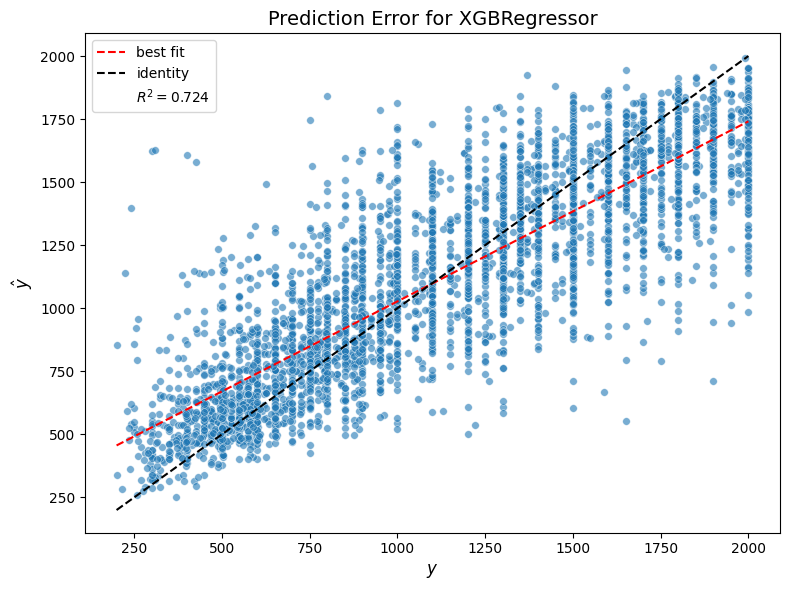

In [525]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Hitung R^2
r2 = r2_score(y_test, y_pred)

# Best fit line
model_fit = LinearRegression()
model_fit.fit(y_test.values.reshape(-1, 1), y_pred)
y_fit_line = model_fit.predict(y_test.values.reshape(-1, 1))
y_fit_line = [y_fit_line.min(), y_fit_line.max()]
x_fit_line = [y_test.min(), y_test.max()]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, s=30, alpha=0.6)

# Plot garis best fit
plt.plot(x_fit_line, y_fit_line, color='red', linestyle='--', label='best fit')

# Plot garis identitas (y = ŷ)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, color='black', linestyle='--', label='identity')

# Label dan judul
plt.xlabel('$y$', fontsize=12)
plt.ylabel(r'$\hat{y}$', fontsize=12)
plt.title('Prediction Error for XGBRegressor', fontsize=14)

# Tambahkan R^2 ke dalam label legenda
plt.plot([], [], ' ', label=f'$R^2 = {r2:.3f}$')

plt.legend()
plt.tight_layout()
plt.show()

In [526]:
import json

# Konversi ke tipe data Python standar
data_to_save = {
    'identity_line': [int(x) for x in lims],                # list of float
    'y_pred': y_pred.astype(float).tolist(),                # array → list of float
    'y_test': y_test.astype(int).tolist(),                  # Series → list of float
    'y_fit_line': [float(x) for x in y_fit_line],           # array → list of float
    'x_fit_line': [float(x) for x in x_fit_line],           # array → list of float
    'r2': float(r2)                                         # float
}

# Simpan ke file JSON
with open('../../data/visualisation/distribution_predict.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)


### Scatter Plot Residuals and Bar Chart Distribution Residuals

C:\Users\munaf\AppData\Local\Temp\ipykernel_13628\1188923893.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


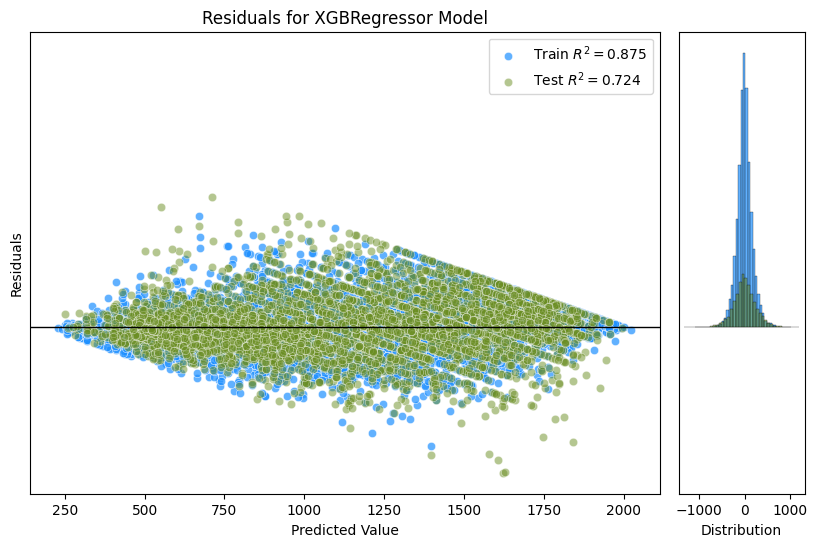

In [527]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Asumsikan sudah ada data:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Hitung residual
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Hitung R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Setup figure
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 2, width_ratios=(5, 1), wspace=0.05)
ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1], sharey=ax)

# Plot scatter residuals
sns.scatterplot(x=y_train_pred, y=residuals_train, color='dodgerblue', alpha=0.7, ax=ax, label=fr'Train $R^2 = {r2_train:.3f}$')
sns.scatterplot(x=y_test_pred, y=residuals_test, color='olivedrab', alpha=0.5, ax=ax, label=fr'Test $R^2 = {r2_test:.3f}$')

# Horizontal zero line
ax.axhline(0, color='black', linewidth=1)

# Labels dan judul
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
ax.set_title("Residuals for XGBRegressor Model")
ax.legend()

# Plot histogram distribusi residual
sns.histplot(residuals_train, bins=40, orientation='horizontal', color='dodgerblue', alpha=0.7, ax=ax_hist)
sns.histplot(residuals_test, bins=40, orientation='horizontal', color='olivedrab', alpha=0.5, ax=ax_hist)

ax_hist.set_xlabel("Distribution")
ax_hist.set_ylabel("")
ax_hist.set_yticks([])

plt.tight_layout()
plt.show()

<h3>Analisa R-Square</h3>
Model memiliki kemampuan sangat baik pada data latih, menjelaskan sekitar 87.5% variasi data.

Performanya juga cukup baik pada data uji (72.4%), meskipun ada sedikit penurunan (gap ±0.15) yang masih tergolong wajar sehingga tidak ada indikasi overfitting berlebihan.

<h3>Pola Residual</h3>
Residual tersebar di sekitar garis horizontal nol, yang merupakan indikator baik bahwa model tidak bias secara sistematis. Namun, kesalahan terbesar cenderung terjadi pada harga menengah (sekitar puncak distribusi prediksi). 

Sementara pada harga ekstrem (sangat rendah dan sangat tinggi), residual lebih kecil dan terdistribusi sempit. Namun, masih ada beberapa residual yang cukup jauh dari residual lain di nilai ekstrem

<h3>Distribusi Residual</h3>
Histogram di sisi kanan menunjukkan distribusi residual yang simetris dan terpusat di nol. Hal ini mengindikasikan bahwa sebagian besar prediksi model mendekati nilai sebenarnya. Puncak yang tajam dan simetris menandakan bahwa sebagian besar kesalahan kecil, dan residual ekstrem jarang terjadi.

Distribusi residual pada data training (biru) dan testing (hijau) serupa, yang mengindikasikan generalisasi yang baik.

In [528]:
import json

# Tentukan bin range dan jumlah bin
bin_edges = np.histogram_bin_edges(np.concatenate([residuals_train, residuals_test]), bins=40)

# Lakukan binning dan simpan dalam variabel
train_bins = pd.cut(residuals_train, bins=bin_edges)
test_bins = pd.cut(residuals_test, bins=bin_edges)

# Hitung jumlah data per bin untuk dilihat dan ubah menjadi DataFrame
train_bin_counts = train_bins.value_counts().reset_index()
test_bin_counts = test_bins.value_counts().reset_index()

# Ganti nama kolom agar lebih jelas
train_bin_counts.columns = ['bin', 'count']
test_bin_counts.columns = ['bin', 'count']

# Sort berdasarkan bin agar urut dari kecil ke besar
train_bin_counts = train_bin_counts.sort_values(by='bin')
test_bin_counts = test_bin_counts.sort_values(by='bin')

# Konversi ke format serializable (string untuk bin kategori)
data_to_save = {
    'y_train_pred': y_train_pred.astype(float).tolist(),
    'y_test_pred': y_test_pred.astype(float).tolist(),
    'train_bin_counts': [
        {'bin': str(row['bin']), 'count': int(row['count'])}
        for _, row in train_bin_counts.iterrows()
    ],
    'test_bin_counts': [
        {'bin': str(row['bin']), 'count': int(row['count'])}
        for _, row in test_bin_counts.iterrows()
    ],
    'residuals_train': residuals_train.astype(float).tolist(),
    'residuals_test': residuals_test.astype(float).tolist(),
    'r2_train': float(r2_train),
    'r2_test': float(r2_test)
}

# Simpan ke file JSON
with open('../../data/visualisation/distribution_residual.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)


### Table Model Result

In [529]:
# Hitung metrik
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

In [530]:
# Buat dict berisi (Train, Test) untuk setiap metrik
metrics = {
    "MAE": (mae_train, mae_test),
    "MSE": (mse_train, mse_test),
    "RMSE": (rmse_train, rmse_test),
    "R²": (r2_train, r2_test),
}
df_eval = pd.DataFrame.from_dict(metrics, orient="index", columns=["Train", "Test"])
display(df_eval)

with open('../../data/visualisation/result_table.json', 'w') as f:
    json.dump(metrics, f, indent=2)

,Train,Test
MAE,125.770434,192.609916
MSE,29170.565509,66480.005819
RMSE,170.793927,257.837169
R²,0.874840,0.723668


### Bar Chart Feature Importance

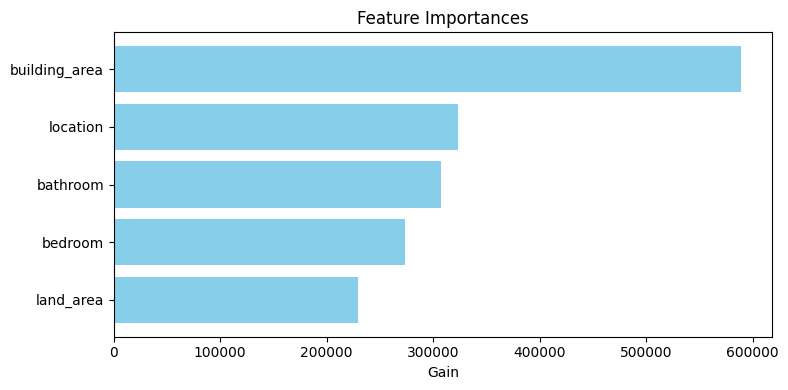

In [531]:
import pandas as pd
import matplotlib.pyplot as plt

# Ambil importance dari model
importance = model.get_booster().get_score(importance_type='gain')

# Jika feature_names tidak terisi saat training, key akan jadi f0, f1, ...
# Konversi ke DataFrame
imp_df = pd.DataFrame({
    'feature': list(X_train.columns),
    'importance': list(importance.values())
})

# Urutkan
imp_df = imp_df.sort_values(by='importance', ascending=False).head(5)

# Plot manual
plt.figure(figsize=(8, 4))
plt.barh(imp_df['feature'], imp_df['importance'], color='skyblue')
plt.xlabel('Gain')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [532]:
imp_df.to_json('../../data/visualisation/feature_importance_table.json', orient='records', indent=2)

### Prediction Error Heatmap

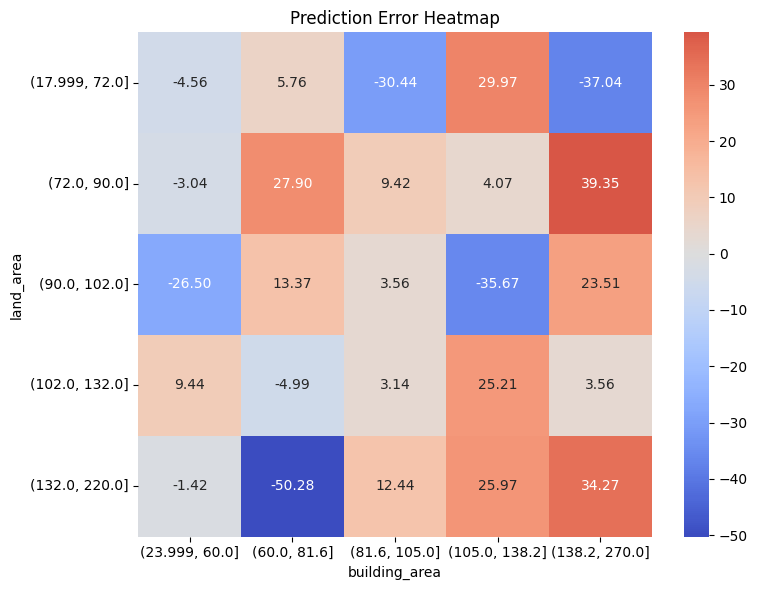

In [533]:
# Misal dua fitur penting
f1, f2 = 'building_area', 'land_area'

# Gabungkan ke dalam DataFrame
X_test_dummy = pd.DataFrame(X_test_encoded, columns=X_test.columns)
df_error = X_test_dummy[[f1, f2]].copy()
df_error['error'] = y_test - y_pred

# Bin-kan fitur
df_error['bin_f1'] = pd.qcut(df_error[f1], q=5)
df_error['bin_f2'] = pd.qcut(df_error[f2], q=5)
df_error.drop(columns=['building_area', 'land_area'], inplace=True)

# Pivot table untuk heatmap
pivot = df_error.pivot_table(values='error', index='bin_f2', columns='bin_f1', aggfunc='mean')

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Prediction Error Heatmap')
plt.xlabel(f1)
plt.ylabel(f2)
plt.tight_layout()
plt.show()


In [534]:
import json

# Ambil label unik dan urut dari bin_f1 (kolom) dan bin_f2 (baris)
bin_f1_labels = sorted(df_error['bin_f1'].unique())
bin_f2_labels = sorted(df_error['bin_f2'].unique())
bin_f2_labels = bin_f2_labels[::-1]

# Konversi label ke string agar bisa disimpan ke JSON
bin_f1_labels_str = [str(label) for label in bin_f1_labels]
bin_f2_labels_str = [str(label) for label in bin_f2_labels]

# Buat array [y_index, x_index, error]
pivot_array = pivot.values
result_array = []

for y_idx, y_label in enumerate(bin_f2_labels):
    for x_idx, x_label in enumerate(bin_f1_labels):
        value = pivot.loc[y_label, x_label]
        result_array.append([y_idx, x_idx, float(value)])

# Simpan ke JSON
data_to_save = {
    'heatmap': result_array,
    'bin_f1_labels': bin_f1_labels_str,
    'bin_f2_labels': bin_f2_labels_str
}

with open('../../data/visualisation/heatmap_residual.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)

<h3>Interpretasi Warna</h3>

- Merah: Error positif → model underestimate (prediksi terlalu rendah).

- Biru: Error negatif → model overestimate (prediksi terlalu tinggi).

- Putih/abu-abu muda: Error mendekati 0 → prediksi relatif akurat.

<h3>Analisis Berdasarkan Heatmap</h3>

1. Prediksiu yang terlalu rendah : 

- building_area 138.2–270.0 & land_area 17.999–72.0 → error = +39.35

- building_area 105.0–138.2 & land_area 17.999–72.0 → error = +29.97

- Nilai error = +150.42. Model terlalu meremehkan dalam memprediksi harga di kombinasi ini, menghasilkan prediksi jauh di dibawah nilai aktual.

2. Prediksi yang terlalu tinggi :

- building_area 81.6–105.0 & land_area 90.0–102.0 → error = -35.67

- building_area 23.999–60.0 & land_area 90.0–102.0 → error = -26.50

- Nilai error = −97.44. Model terlalu optimis dalam memprediksi harga di kombinasi ini, menghasilkan prediksi jauh di atas nilai aktual.

3. Area dengan Prediksi Akurat :

- building_area 81.6–138.2 dan land_area 90–132.0 → error = ±5

- Model bekerja dengan baik pada kombinasi ini.

### Bar Cahrt : Top & Bottom 5 Lokasi Berdasarkan Rata-rata Harga Rumah

C:\Users\munaf\AppData\Local\Temp\ipykernel_13628\1066619671.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combined.values, y=combined.index, palette='coolwarm')


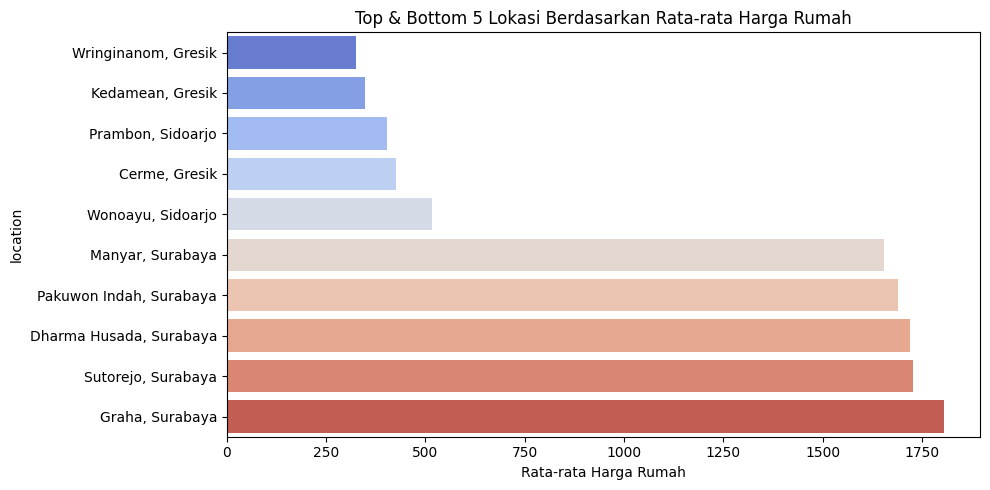

In [535]:
import matplotlib.pyplot as plt
import seaborn as sns

avg_price = rumah123_df.groupby('location')['price'].mean().sort_values()

# Ambil top 5 dan bottom 5
top5 = avg_price.tail(5)
bottom5 = avg_price.head(5)
combined = pd.concat([bottom5, top5])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=combined.values, y=combined.index, palette='coolwarm')
plt.xlabel('Rata-rata Harga Rumah')
plt.title('Top & Bottom 5 Lokasi Berdasarkan Rata-rata Harga Rumah')
plt.tight_layout()
plt.show()


In [536]:
# Ekstrak label dan nilai
label_top5 = top5.index.tolist()
value_top5 = top5.values.tolist()

label_bottom5 = bottom5.index.tolist()
value_bottom5 = bottom5.values.tolist()

# Simpan ke dictionary
data_dict = {
    'label_top5': label_top5,
    'value_top5': value_top5,
    'label_bottom5': label_bottom5,
    'value_bottom5': value_bottom5
}

# Simpan ke file JSON
with open('../../data/visualisation/barchart_top_bottom_mean_price.json', 'w') as f:
    json.dump(data_dict, f, indent=2)


### Heatmap Harga Berdasarkan Luas Tanah dan Luas Bangunan

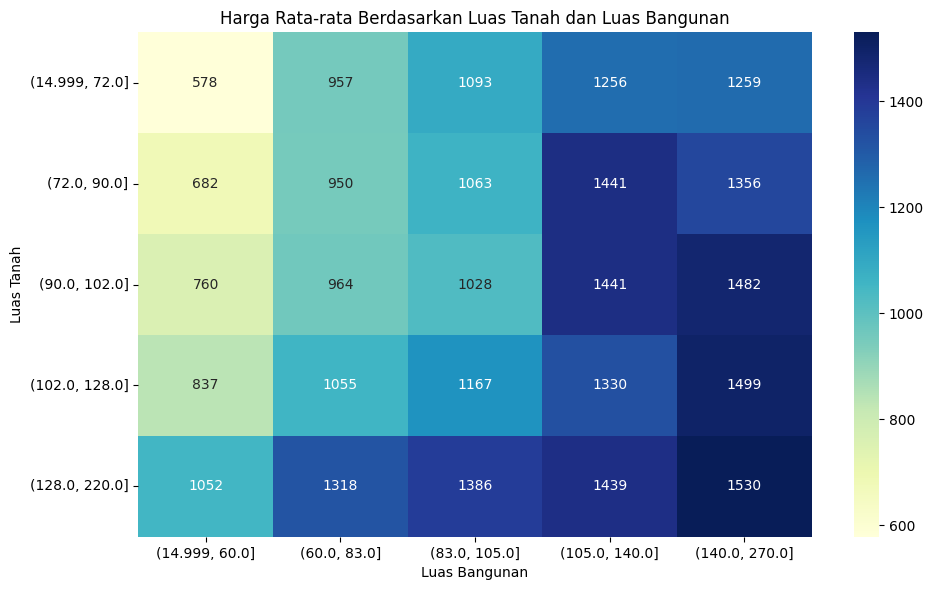

In [537]:
# Buat bin
rumah123_df['land_bin'] = pd.qcut(rumah123_df['land_area'], q=5)
rumah123_df['building_bin'] = pd.qcut(rumah123_df['building_area'], q=5)

# Pivot table
pivot = rumah123_df.pivot_table(index='land_bin', columns='building_bin', values='price', aggfunc='mean')

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Harga Rata-rata Berdasarkan Luas Tanah dan Luas Bangunan')
plt.xlabel('Luas Bangunan')
plt.ylabel('Luas Tanah')
plt.tight_layout()
plt.show()


In [538]:
# Pastikan urutan kolom (x) dari kecil ke besar dan index (y) dari besar ke kecil
pivot_sorted = pivot.sort_index(ascending=False).sort_index(axis=1)

# Dapatkan nilai matrix sebagai array [y, x, value]
data_array = []
for y_idx, y_label in enumerate(pivot_sorted.index):
    for x_idx, x_label in enumerate(pivot_sorted.columns):
        value = pivot_sorted.loc[y_label, x_label]
        if not np.isnan(value):
            data_array.append([y_idx, x_idx, float(value)])

# Buat list label sumbu x dan y (terurut kecil ke besar)
x_labels = [str(interval) for interval in sorted(pivot.columns)]
y_labels = [str(interval) for interval in sorted(pivot.index)]

# Simpan dalam dictionary
heatmap_data = {
    "matrix_data": data_array,
    "x_labels": x_labels,
    "y_labels": y_labels
}

# Simpan ke JSON
with open('../../data/visualisation/heatmap_price_land_building.json', 'w') as f:
    json.dump(heatmap_data, f, indent=2)

### Pie Chart : Proporsi Jumlah Kamar Mandi dan Kamar Tidur

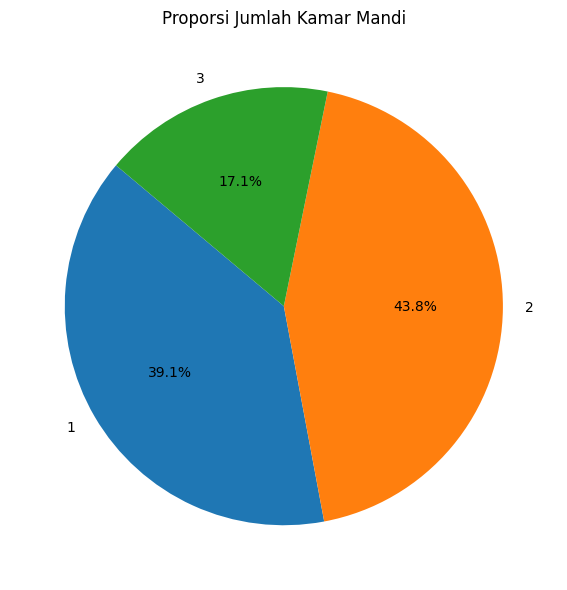

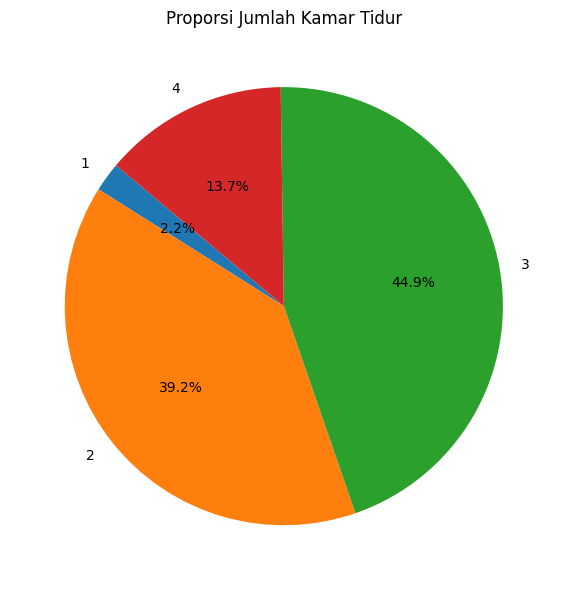

In [539]:
import matplotlib.pyplot as plt

# Pie chart untuk kamar mandi
bathroom_counts = rumah123_df['bathroom'].value_counts().sort_index()
plt.figure(figsize=(6, 6))
plt.pie(bathroom_counts, labels=bathroom_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proporsi Jumlah Kamar Mandi')
plt.tight_layout()
plt.show()

# Pie chart untuk kamar tidur
bedroom_counts = rumah123_df['bedroom'].value_counts().sort_index()
plt.figure(figsize=(6, 6))
plt.pie(bedroom_counts, labels=bedroom_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proporsi Jumlah Kamar Tidur')
plt.tight_layout()
plt.show()


In [540]:
# Hitung jumlah dan persentase kamar mandi
bathroom_counts = rumah123_df['bathroom'].value_counts().sort_index()
bathroom_percentages = (bathroom_counts / bathroom_counts.sum() * 100).round(2)

# Hitung jumlah dan persentase kamar tidur
bedroom_counts = rumah123_df['bedroom'].value_counts().sort_index()
bedroom_percentages = (bedroom_counts / bedroom_counts.sum() * 100).round(2)

# Buat dictionary
summary_dict = {
    'label_bathrooms': bathroom_counts.index.tolist(),
    'count_bathrooms': bathroom_counts.tolist(),
    'percentage_bathrooms': bathroom_percentages.tolist(),
    'label_bedrooms': bedroom_counts.index.tolist(),
    'count_bedrooms': bedroom_counts.tolist(),
    'percentage_bedrooms': bedroom_percentages.tolist(),
}

# Simpan ke file JSON
with open('../../data/visualisation/pie_chart_kamar.json', 'w') as f:
    json.dump(summary_dict, f, indent=2)

### Learning Curve

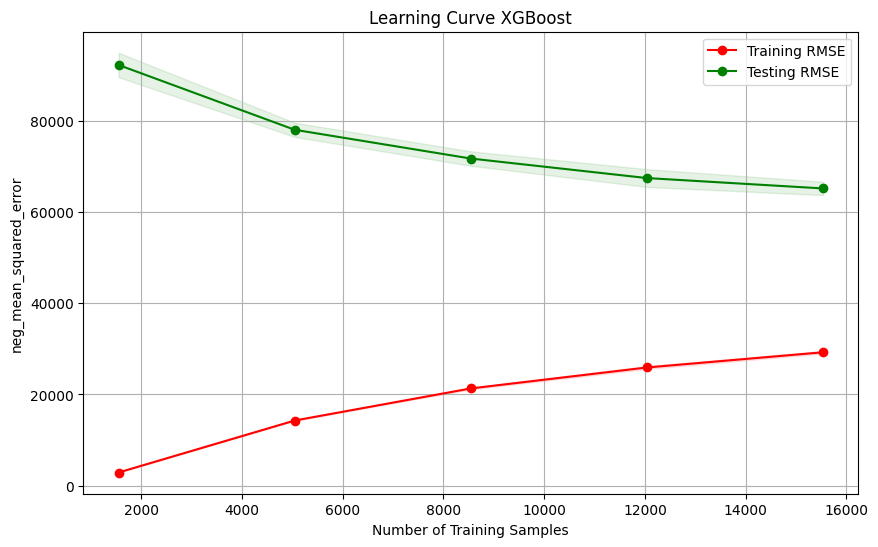

In [541]:
# Gabungkan array menjadi satu
X_scaled = np.vstack([X_train_scaled, X_test_scaled])

# Gabungkan y
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Buat DataFrame dari array X_scaled
X = pd.DataFrame(X_scaled, columns=[X_train.columns])

# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring="neg_mean_squared_error"
)
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve XGBoost")
plt.xlabel("Number of Training Samples")
plt.ylabel("neg_mean_squared_error")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training RMSE")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Testing RMSE")

plt.legend(loc="best")
plt.show()

In [542]:
import json

# Konversi ke list
data_to_save = {
    'train_sizes': train_sizes.astype(float).tolist(),
    'train_scores': train_scores_mean.astype(float).tolist(),
    'test_scores': test_scores_mean.astype(float).tolist()
}

# Simpan ke file JSON
with open('../../data/visualisation/learning_curve.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)


### batas